In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import pandas as pd
import time
from igraph import *
import csv

In [2]:
# Generate Graph , nodes=10, edges=30 and export to csv
G = Graph.Erdos_Renyi(n=100,m=300,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))

b=G.get_edgelist()

with open('b.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    #write.writerow(fields)
    write.writerows(b)

In [2]:
#Read csv as Graph object

df=pd.read_csv("b.csv", header=None)

In [3]:
df

,0,1
0,0,53
1,1,86
2,2,99
3,2,37
4,2,64
...,...,...
295,98,24
296,98,30
297,98,34
298,99,10


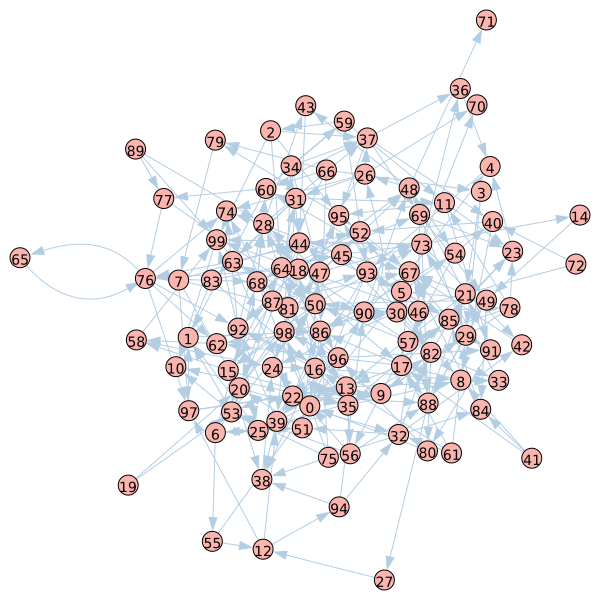

In [4]:
source=df[0]
s=list(source)

target=df[1]
t=target.tolist()

g1 = Graph(directed=True)
g1.add_vertices(range(100))
g1.add_edges(zip(s,t))

# Plot graph
g1.vs["label"], g1.es["color"], g1.vs["color"] = range(100), "#B3CDE3", "#FBB4AE"
#png("my_plot.png", 600, 600)
#dev.off()
plot(g1,bbox = (200,200),margin = 20,layout = g1.layout("kk"),)
plot(g1, "g2.png", dpi=300)

In [25]:
#convert df by adding compatibility factor

df['compf'] = np.random.randint(0,2, size=len(df))

In [26]:
df

,0,1,compf
0,0,53,0
1,1,86,1
2,2,99,0
3,2,37,1
4,2,64,0
...,...,...,...
295,98,24,1
296,98,30,0
297,98,34,1
298,99,10,1


In [27]:
#removing entries where compatibility = 0
df1= df[df['compf'] != 0]

In [28]:
df1

,0,1,compf
1,1,86,1
3,2,37,1
5,2,95,1
6,3,21,1
7,3,29,1
...,...,...,...
292,97,13,1
293,97,22,1
295,98,24,1
297,98,34,1


In [49]:
df1.to_csv('b1.csv')

In [50]:
#regenerating graph

source=df1[0]
s=list(source)

target=df1[1]
t=target.tolist()

g2 = Graph(directed=True)
g2.add_vertices(range(100))
g2.add_edges(zip(s,t))

# Plot graph
g2.vs["label"], g2.es["color"], g2.vs["color"] = range(100), "#B3CDE3", "#FBB4AE"
#png("my_plot.png", 600, 600)
#dev.off()
plot(g2,bbox = (200,200),margin = 20,layout = g2.layout("kk"),)
plot(g2, "g2_modified.png", dpi=300)

InternalError: Error at src/graph/type_indexededgelist.c:270: cannot add edges. -- Invalid vertex id

In [31]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        print(A)
        
    return(np.mean(spread))


In [32]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)


In [33]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)


In [34]:
# Run algorithms with unmodified graph
celf_output1   = celf(g1,10,p = 0.1,mc = 100)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 53]
[0]
[0, 53]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 53]
[0]
[0, 53]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 53, 10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 53]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 53]
[0]
[0, 53]
[0]
[0]
[0]
[0]
[0, 53]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 53]
[0]
[0]
[0]
[0]
[0]
[0, 53]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1, 86, 0, 53]
[1]
[1, 86, 0, 53]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1, 86, 0, 53]
[1]
[1, 86, 0, 53]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1, 86, 0, 53, 10]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1, 86, 0, 53]
[1]
[1]
[1]
[1]
[1]
[1]
[1, 86, 0, 53]
[1]
[1, 86, 0, 53]
[1]
[1]
[1]
[1]
[1, 86, 0, 53]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1, 86, 0, 53]
[1]
[1]
[1]
[1]
[1]
[1, 86, 0, 53]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[2, 95, 82, 80]
[2, 64,

[15, 64]
[15]
[15, 35, 8, 17, 13, 33, 73, 88, 14, 49, 21, 5, 0, 53]
[15]
[15, 64, 35, 8, 17, 85, 13, 86, 23, 0, 33, 4, 73, 53, 93, 88, 44, 14, 49, 21, 5, 98, 34, 59, 37, 2, 36, 95, 99, 52, 10, 67]
[15]
[15]
[15]
[15]
[15]
[15]
[15]
[15, 58]
[15]
[15]
[15]
[15]
[15, 58, 35, 24, 8, 56, 16, 17, 88, 38, 13, 21, 28, 62, 33, 67, 43, 81, 18, 99, 4, 39, 73, 44, 76, 46, 60, 1, 68, 5, 70, 10, 42, 14, 78, 50, 59, 92, 93, 0, 2, 9, 49, 53, 86, 23, 85, 25, 63, 37, 82, 51, 22, 95, 36, 69, 6, 47, 80, 52, 64, 55, 31, 11]
[15]
[15]
[15]
[15]
[15]
[15, 38]
[15, 64, 38, 20, 32, 98, 24, 82, 34, 46, 33, 44, 52, 88, 59, 95, 68, 11, 79, 53, 27, 1, 91, 28, 69, 80, 96, 37, 40, 87, 39, 74, 92]
[15]
[15]
[15]
[15, 64]
[15]
[15]
[15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[15]
[15]
[15, 38]
[15, 38]
[15]
[15]
[15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[15]
[15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[15, 64]
[15, 64]
[15]
[15]
[15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[15, 58]
[15]
[15, 38]
[15]
[15]
[1

[21, 67, 13, 81, 4, 60, 33, 1, 39, 73, 59, 93, 0, 2, 70, 38, 42, 14, 85, 86, 37, 49, 53, 23, 24, 95, 36, 69, 5, 10, 16, 82, 52, 88, 8, 80, 28, 17, 18, 43, 99, 76, 44, 46, 62, 68, 78, 50, 58, 92, 9, 63, 25, 15, 51, 35, 22, 56, 6, 47, 64, 55, 31, 11]
[21]
[21]
[21]
[21]
[21]
[21, 48, 29, 49, 84, 85, 67, 17, 23]
[21, 48, 29, 54, 49, 91, 57, 80, 50, 84, 96, 73, 85, 67, 36, 39, 44, 87, 98, 74, 15, 17, 53, 92, 64, 1, 34, 38, 86, 23, 24, 28, 37, 20, 59, 62, 95, 32, 40, 11, 79, 82, 52, 46, 88, 33, 68, 27, 69]
[21]
[21]
[21]
[21]
[21]
[21]
[21, 13, 33, 73, 14, 49, 5, 0, 53]
[21]
[21]
[21, 48, 29, 49, 84, 85, 67, 17, 23]
[21, 48, 29, 71, 49, 84, 85, 67, 17, 88, 23, 27]
[21]
[21]
[21, 13, 33, 73, 14, 49, 5, 0, 53]
[21]
[21, 13, 33, 73, 14, 49, 5, 0, 53]
[21]
[21]
[21]
[21]
[21, 13, 33, 73, 14, 49, 5, 0, 53]
[21, 67, 60, 59, 93, 85]
[21]
[21, 48, 29, 49, 84, 85, 67, 17, 23]
[21]
[21]
[21, 48, 29, 49, 84, 85, 67, 17, 23]
[21]
[21]
[21]
[21]
[21]
[21]
[21, 48, 29, 49, 84, 85, 67, 17, 23]
[21]
[21]
[

[29]
[29, 35, 91, 8, 85, 21, 17, 13, 23, 33, 4, 86, 0, 73, 93, 88, 44, 53, 14, 49, 98, 5, 34, 15, 64, 59, 37, 2, 36, 95, 99, 52, 10, 67]
[29]
[29]
[29]
[29]
[29]
[29]
[29]
[29, 88]
[29]
[29]
[29]
[29]
[29, 88, 35, 8, 56, 21, 24, 17, 67, 13, 33, 4, 16, 81, 60, 62, 1, 38, 39, 73, 58, 59, 28, 93, 0, 2, 70, 42, 43, 14, 18, 85, 86, 99, 37, 44, 76, 46, 49, 53, 23, 95, 36, 69, 5, 68, 10, 78, 50, 82, 52, 92, 9, 15, 80, 25, 63, 51, 22, 6, 47, 64, 55, 31, 11]
[29]
[29]
[29]
[29]
[29]
[29, 49, 84, 85, 67, 17, 23]
[29, 49, 91, 80, 84, 96, 85, 67, 39, 87, 17, 74, 92, 15, 64, 38, 86, 23, 28, 20, 37, 62, 32, 98, 40, 95, 34, 46, 79, 82, 52, 24, 33, 68, 44, 88, 59, 53, 27, 11, 69, 1]
[29]
[29]
[29]
[29, 91]
[29]
[29]
[29, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[29]
[29]
[29, 49, 84, 85, 67, 17, 23]
[29, 49, 84, 85, 67, 17, 88, 23, 27]
[29]
[29]
[29, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[29]
[29, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[29, 91]
[29, 91]
[29]
[29]
[29, 35, 8, 17, 13, 33, 73, 14, 4

[37, 95]
[37, 36, 4, 93, 0, 53]
[37]
[37, 36, 4, 93, 0, 53]
[37, 40, 52, 68, 28]
[37, 40, 52, 68, 28]
[37]
[37]
[37, 95]
[37, 69, 49, 88]
[37, 95]
[37, 95]
[37]
[37, 36, 4, 93, 0, 53]
[37]
[37, 36, 95, 4, 52, 67, 93, 0, 53]
[37]
[37]
[37]
[37]
[37]
[37]
[37]
[37, 69, 49, 88]
[37]
[37]
[37]
[37]
[37, 36, 69, 49, 4, 23, 88, 5, 93, 0, 21, 85, 53, 67, 13, 81, 33, 10, 60, 73, 59, 1, 39, 2, 38, 70, 42, 14, 86, 24, 95, 16, 82, 52, 8, 80, 28, 17, 18, 43, 99, 76, 44, 46, 62, 68, 78, 50, 58, 92, 9, 63, 25, 15, 51, 35, 22, 56, 6, 47, 64, 55, 31, 11]
[37]
[37]
[37]
[37]
[37]
[37, 40, 52, 68, 28]
[37, 40, 95, 52, 79, 68, 28, 69, 96, 46, 88, 39, 87, 74, 27, 92, 15, 64, 38, 20, 32, 98, 24, 82, 34, 33, 59, 44, 11, 53, 1, 91, 80]
[37]
[37]
[37]
[37, 95]
[37]
[37]
[37, 36, 4, 93, 0, 53]
[37]
[37]
[37, 40, 52, 68, 28]
[37, 40, 52, 68, 28]
[37]
[37]
[37, 36, 4, 93, 0, 53]
[37]
[37, 36, 4, 93, 0, 53]
[37, 95]
[37, 95]
[37]
[37]
[37, 36, 4, 93, 0, 53]
[37, 69, 49, 88]
[37]
[37, 40, 52, 68, 28]
[37]
[37]
[37

[44, 67, 60, 59, 93, 85]
[44, 53, 1]
[44]
[44]
[44]
[44, 98, 34, 59]
[44, 5, 0, 53]
[44]
[44, 5, 0, 53]
[44, 53, 1]
[44, 53, 1]
[44]
[44]
[44, 98, 34, 59]
[44, 67, 60, 59, 93, 85]
[44, 98, 34, 59]
[44, 98, 34, 59]
[44]
[44, 5, 0, 53]
[44]
[44, 98, 5, 0, 34, 15, 64, 35, 37, 53, 59, 2, 36, 8, 17, 85, 95, 99, 4, 13, 52, 86, 23, 33, 10, 67, 93, 73, 88, 14, 49, 21]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44, 67, 60, 59, 93, 85]
[44]
[44]
[44]
[44]
[44, 67, 5, 0, 4, 60, 53, 1, 59, 93, 2, 10, 85, 86, 37, 95, 23, 82, 36, 69, 52, 80, 49, 21, 88, 13, 81, 33, 73, 39, 70, 42, 38, 14, 24, 16, 8, 28, 17, 18, 43, 62, 99, 76, 46, 68, 78, 50, 58, 92, 9, 63, 25, 15, 51, 35, 22, 56, 6, 47, 64, 55, 31, 11]
[44]
[44]
[44]
[44]
[44]
[44, 53, 1]
[44, 98, 53, 24, 1, 34, 59, 95, 11, 79, 91, 80, 96, 39, 87, 74, 92, 15, 64, 28, 38, 20, 37, 32, 40, 82, 52, 46, 88, 33, 68, 27, 69]
[44]
[44]
[44]
[44, 98, 34, 59]
[44]
[44]
[44, 5, 0, 53]
[44]
[44]
[44, 53, 1]
[44, 53, 1]
[44]
[44]
[44, 5, 0, 53]
[44]
[44, 5, 0, 53]
[44

[50, 63, 76, 97, 68, 60, 22, 59, 35, 56, 93, 88, 85]
[50, 49, 84, 85, 67, 17, 23]
[50]
[50]
[50]
[50, 73, 44, 98, 34, 59]
[50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[50]
[50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[50, 49, 84, 85, 67, 17, 23]
[50, 49, 84, 85, 67, 17, 23]
[50]
[50]
[50, 73, 44, 98, 34, 59]
[50, 63, 76, 68, 60, 59, 93, 85]
[50, 73, 44, 98, 34, 59]
[50, 73, 44, 98, 34, 59]
[50]
[50, 15, 35, 8, 17, 13, 33, 73, 88, 14, 49, 21, 5, 0, 53]
[50]
[50, 73, 15, 64, 35, 44, 14, 88, 98, 5, 8, 17, 49, 85, 21, 0, 34, 13, 86, 23, 33, 4, 37, 53, 59, 2, 36, 93, 95, 99, 52, 10, 67]
[50]
[50]
[50]
[50]
[50]
[50]
[50]
[50, 63, 76, 68, 60, 59, 93, 85]
[50]
[50]
[50]
[50]
[50, 15, 63, 58, 35, 76, 22, 68, 8, 9, 56, 24, 88, 92, 62, 0, 99, 16, 17, 82, 21, 53, 25, 60, 1, 67, 38, 10, 13, 80, 51, 59, 28, 33, 2, 4, 6, 43, 47, 81, 18, 86, 93, 64, 37, 39, 73, 44, 46, 85, 55, 95, 36, 5, 69, 70, 42, 14, 78, 52, 23, 31, 49, 11]
[50]
[50]
[50]
[50]
[50]
[50, 49, 84, 85, 67, 17, 23]
[50, 73, 4

[57]
[57, 50, 49, 84, 85, 67, 17, 23]
[57, 50, 49, 84, 85, 67, 17, 88, 23, 27]
[57]
[57]
[57, 18, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[57]
[57, 18, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[57]
[57]
[57]
[57]
[57, 18, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[57, 56, 88]
[57]
[57, 50, 49, 84, 85, 67, 17, 23]
[57]
[57]
[57, 50, 49, 84, 85, 67, 17, 23]
[57]
[57]
[57]
[57]
[57]
[57]
[57, 50, 49, 84, 85, 67, 17, 23]
[57]
[57]
[57, 18, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[57]
[57]
[57]
[57]
[57]
[57, 18, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[57]
[58]
[58]
[58, 99, 87, 15, 38]
[58]
[58]
[58]
[58]
[58, 24, 16, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[58]
[58, 24, 16, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[58, 99, 87, 15, 38]
[58, 99, 87, 15, 38]
[58]
[58]
[58]
[58]
[58]
[58]
[58]
[58, 24, 16, 8, 92, 17, 25, 1, 13, 33, 86, 0, 73, 88, 53, 14, 49, 21, 5]
[58

[64, 20, 32, 98, 24, 82, 34, 46, 33, 44, 52, 88, 59, 95, 68, 11, 79, 53, 27, 1, 91, 28, 69, 80, 96, 37, 40, 87, 39, 74, 92, 15, 38]
[64]
[64]
[64]
[64]
[64]
[64]
[64, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[64]
[64]
[64, 20, 32, 46, 52, 68, 28, 37, 40]
[64, 20, 32, 46, 52, 68, 28, 37, 40]
[64]
[64]
[64, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[64]
[64, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[64]
[64]
[64]
[64]
[64, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[64, 31, 81]
[64]
[64, 20, 32, 46, 52, 68, 28, 37, 40]
[64]
[64]
[64, 20, 32, 46, 52, 68, 28, 37, 40]
[64]
[64]
[64]
[64]
[64]
[64]
[64, 20, 32, 46, 52, 68, 28, 37, 40]
[64]
[64]
[64, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[64]
[64]
[64]
[64]
[64]
[64, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[64]
[65]
[65]
[65]
[65]
[65]
[65]
[65]
[65, 76, 62, 58, 24, 16, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[65]
[65, 76, 62, 58, 24, 16, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[65]
[65]
[65]
[65]
[65]
[65]
[65]
[65]
[6

[72, 40, 52, 68, 28, 37]
[72]
[72]
[72, 30, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[72]
[72, 30, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[72]
[72]
[72]
[72]
[72, 30, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[72]
[72]
[72, 40, 52, 68, 28, 37]
[72]
[72]
[72, 40, 52, 68, 28, 37]
[72]
[72]
[72]
[72]
[72]
[72]
[72, 40, 52, 68, 28, 37]
[72]
[72]
[72, 30, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[72]
[72]
[72]
[72]
[72]
[72, 30, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[72]
[73]
[73, 88, 42]
[73, 36]
[73]
[73]
[73]
[73, 44, 98, 34, 59]
[73, 14, 49, 5, 0, 53]
[73, 88]
[73, 14, 49, 5, 0, 53]
[73, 36]
[73, 99, 36, 87, 15, 38]
[73, 70]
[73]
[73, 44, 98, 34, 59]
[73, 42]
[73, 44, 98, 34, 59]
[73, 44, 98, 34, 59]
[73]
[73, 88, 14, 49, 21, 5, 13, 0, 33, 53]
[73, 70]
[73, 88, 44, 14, 49, 21, 5, 98, 0, 34, 13, 15, 64, 33, 35, 37, 53, 59, 2, 36, 8, 17, 85, 95, 99, 4, 52, 86, 23, 10, 67, 93]
[73]
[73]
[73]
[73]
[73]
[73]
[73]
[73, 42]
[73]
[73]
[73]
[

[85, 23, 4, 93, 0, 53]
[85, 67, 17, 23]
[85, 67, 17, 23]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85, 23, 4, 93, 0, 53, 10]
[85]
[85]
[85]
[85]
[85]
[85, 67, 17, 23]
[85, 67, 17, 86, 23, 62, 87, 74, 15, 64, 38, 20, 32, 98, 24, 82, 34, 46, 33, 44, 52, 88, 59, 95, 68, 11, 79, 53, 27, 1, 91, 28, 69, 80, 96, 37, 40, 39, 92]
[85]
[85]
[85]
[85]
[85]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85]
[85, 67, 17, 23]
[85, 67, 17, 88, 23, 27]
[85]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85]
[85]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85]
[85, 67, 17, 23]
[85]
[85]
[85, 67, 17, 23]
[85]
[85]
[85]
[85]
[85]
[85]
[85, 67, 17, 23]
[85]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85]
[85]
[85]
[85]
[85, 23, 4, 93, 0, 53]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[85]
[86]
[86]
[86, 62, 87, 15, 38]
[86]
[86]
[86]
[86]
[86, 0, 53]
[86]
[86, 0, 53]
[86, 62, 87, 15, 38]
[86, 

[91, 21, 67, 13, 81, 4, 60, 33, 1, 39, 73, 59, 93, 0, 2, 70, 38, 42, 14, 85, 86, 37, 49, 53, 23, 24, 95, 36, 69, 5, 10, 16, 82, 52, 88, 8, 80, 28, 17, 18, 43, 99, 76, 44, 46, 62, 68, 78, 50, 58, 92, 9, 63, 25, 15, 51, 35, 22, 56, 6, 47, 64, 55, 31, 11]
[91]
[91]
[91]
[91]
[91]
[91, 80, 96, 39, 92, 28, 37, 40, 52, 68]
[91, 80, 96, 39, 87, 74, 92, 15, 64, 28, 38, 20, 37, 32, 98, 40, 95, 34, 46, 79, 82, 52, 24, 33, 68, 44, 88, 59, 53, 27, 11, 69, 1]
[91]
[91]
[91]
[91]
[91]
[91]
[91, 21, 13, 33, 73, 14, 49, 5, 0, 53]
[91]
[91]
[91, 80, 96, 39, 92, 28, 37, 40, 52, 68]
[91, 80, 96, 39, 92, 99, 28, 37, 87, 40, 93, 15, 52, 38, 68]
[91]
[91]
[91, 21, 13, 33, 73, 14, 49, 5, 0, 53]
[91]
[91, 21, 13, 33, 73, 14, 49, 5, 0, 53]
[91]
[91]
[91]
[91]
[91, 21, 13, 33, 73, 14, 49, 5, 0, 53]
[91]
[91]
[91, 80, 96, 39, 92, 28, 37, 40, 52, 68]
[91]
[91]
[91, 80, 96, 39, 92, 28, 37, 40, 52, 68]
[91]
[91]
[91]
[91]
[91]
[91]
[91, 80, 96, 39, 92, 28, 37, 40, 52, 68]
[91]
[91]
[91, 21, 13, 33, 73, 14, 49, 5, 0

[97, 1, 86, 0, 53]
[97]
[97]
[97]
[97]
[97, 1, 86, 0, 53]
[97, 22, 35, 56, 88]
[97]
[97, 13, 56, 53, 1]
[97]
[97]
[97, 13, 56, 53, 1]
[97]
[97]
[97]
[97]
[97]
[97]
[97, 13, 56, 53, 1]
[97]
[97]
[97, 1, 86, 0, 53]
[97]
[97]
[97]
[97]
[97]
[97, 1, 86, 0, 53]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[97]
[98]
[98, 30, 81]
[98, 24, 95, 79]
[98]
[98]
[98]
[98, 34, 59]
[98, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[98]
[98, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[98, 24, 95, 79]
[98, 24, 95, 79]
[98]
[98]
[98, 34, 59]
[98, 30, 81]
[98, 34, 59]
[98, 34, 59]
[98]
[98, 15, 35, 8, 17, 13, 33, 73, 88, 14, 49, 21, 5, 0, 53]
[98]
[98, 34, 15, 64, 59, 35, 37, 2, 36, 8, 17, 85, 95, 99, 4, 13, 52, 86, 23, 0, 33, 67, 10, 93, 73, 53, 88, 44, 14, 49, 21, 5]
[98]
[98]
[98]
[98]
[98]
[98]
[98]
[98, 30, 81]
[98]
[98]
[98]
[98]
[98, 30, 15, 8, 81, 58, 35, 24, 17, 56, 39, 38, 13, 16, 88, 62, 33, 28, 21, 73, 18, 67, 43, 99, 4, 70, 42, 76, 44, 46, 14, 60, 1, 68, 5, 10, 78,

[47, 57, 18, 28, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 57]
[47, 57]
[47, 57, 48, 50, 49, 29, 84, 85, 67, 17, 23]
[47, 57, 48, 50, 49, 29, 71, 84, 85, 67, 17, 88, 23, 27]
[47, 57]
[47, 57]
[47, 57, 18, 28, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 57]
[47, 57, 18, 28, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 57, 73, 44, 98, 34, 59]
[47, 57, 73, 44, 98, 34, 59]
[47, 57]
[47, 57]
[47, 57, 18, 28, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 57, 64, 56, 88, 31, 81]
[47, 57]
[47, 57, 48, 50, 49, 29, 84, 85, 67, 17, 23]
[47, 57]
[47, 57]
[47, 57, 48, 50, 49, 29, 84, 85, 67, 17, 23]
[47, 57]
[47, 57]
[47, 57]
[47, 57]
[47, 57]
[47, 57]
[47, 57, 48, 50, 49, 29, 84, 85, 67, 17, 23]
[47, 57]
[47, 57]
[47, 57, 18, 28, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 57]
[47, 57]
[47, 57]
[47, 57]
[47, 57]
[47, 57, 18, 28, 46, 50, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 57]
[47, 57]
[47, 57, 73, 44, 98, 34, 59]
[4

[47, 39, 28, 38, 24, 18, 16, 46, 8, 50, 92, 17, 25, 15, 1, 35, 13, 33, 86, 0, 73, 88, 53, 14, 49, 21, 5]
[47, 39]
[47, 39, 73, 28, 38, 96, 44, 14, 18, 88, 24, 98, 5, 46, 16, 49, 21, 87, 25, 92, 0, 1, 34, 35, 8, 74, 13, 15, 50, 64, 33, 37, 17, 53, 86, 85, 59, 2, 36, 95, 23, 99, 4, 52, 10, 67, 93]
[47, 39]
[47, 39]
[47, 39]
[47, 39]
[47, 39]
[47, 39]
[47, 39]
[47, 39, 64, 31, 81]
[47, 39]
[47, 39]
[47, 39]
[47, 39]
[47, 39, 64, 28, 38, 43, 17, 18, 24, 31, 99, 11, 44, 13, 46, 76, 16, 81, 88, 62, 33, 67, 68, 5, 8, 10, 78, 50, 21, 23, 58, 92, 95, 0, 4, 73, 9, 15, 82, 52, 53, 25, 60, 63, 1, 35, 70, 42, 14, 80, 51, 22, 59, 93, 2, 6, 49, 85, 86, 56, 37, 55, 36, 69]
[47, 39]
[47, 39]
[47, 39]
[47, 39]
[47, 39]
[47, 39, 48, 92, 28, 29, 49, 37, 40, 84, 52, 85, 67, 68, 17, 23]
[47, 39, 48, 73, 92, 36, 74, 44, 54, 28, 29, 96, 98, 37, 49, 53, 57, 91, 1, 34, 40, 80, 50, 84, 87, 24, 95, 79, 15, 52, 85, 59, 64, 67, 68, 38, 11, 17, 20, 69, 32, 86, 46, 23, 88, 82, 62, 33, 27]
[47, 39]
[47, 39]
[47, 39]
[

[47, 46]
[47, 46, 88, 73, 99, 44, 98, 34, 59]
[47, 46]
[47, 46]
[47, 46, 50, 28, 18, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 46]
[47, 46]
[47, 46, 48, 52, 68, 29, 49, 28, 84, 37, 40, 85, 67, 17, 23]
[47, 46, 48, 52, 68, 29, 71, 49, 28, 84, 37, 40, 85, 67, 17, 88, 23, 27]
[47, 46]
[47, 46]
[47, 46, 50, 28, 18, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 46]
[47, 46, 50, 28, 18, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 46, 88, 73, 44, 98, 34, 59]
[47, 46, 88, 73, 44, 98, 34, 59]
[47, 46]
[47, 46]
[47, 46, 50, 28, 18, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 46, 64, 78, 31, 23, 81]
[47, 46]
[47, 46, 48, 52, 68, 29, 49, 28, 84, 37, 40, 85, 67, 17, 23]
[47, 46]
[47, 46]
[47, 46, 48, 52, 68, 29, 49, 28, 84, 37, 40, 85, 67, 17, 23]
[47, 46]
[47, 46]
[47, 46]
[47, 46]
[47, 46]
[47, 46]
[47, 46, 48, 52, 68, 29, 49, 28, 84, 37, 40, 85, 67, 17, 23]
[47, 46]
[47, 46]
[47, 46, 50, 28, 18, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 46]
[47, 46]
[47, 46]
[47, 

[47, 75]
[47, 75]
[47, 75, 73, 86, 44, 98, 34, 59]
[47, 20]
[47, 20, 64, 31, 81]
[47, 20, 48, 32, 29, 46, 49, 52, 84, 68, 28, 85, 67, 37, 40, 17, 23]
[47, 20]
[47, 20]
[47, 20]
[47, 20, 73, 98, 34, 44, 59]
[47, 20, 28, 6, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 20]
[47, 20, 28, 6, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 20, 48, 32, 29, 46, 49, 52, 84, 68, 28, 85, 67, 37, 40, 17, 23]
[47, 20, 48, 32, 29, 46, 49, 52, 84, 68, 28, 85, 67, 37, 40, 17, 23]
[47, 20]
[47, 20]
[47, 20, 73, 98, 34, 44, 59]
[47, 20, 64, 31, 81]
[47, 20, 73, 98, 34, 44, 59]
[47, 20, 73, 98, 34, 44, 59]
[47, 20]
[47, 20, 28, 6, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 88, 14, 49, 21, 5]
[47, 20]
[47, 20, 73, 98, 28, 6, 96, 34, 68, 44, 14, 15, 18, 88, 25, 0, 64, 1, 35, 37, 69, 5, 46, 49, 21, 87, 59, 92, 2, 36, 8, 74, 13, 17, 50, 85, 53, 23, 86, 95, 33, 99, 4, 52, 10, 67, 93]
[47, 20]
[47, 20]
[47, 20]
[47, 20]
[47, 20]
[47, 20]
[47, 20

[47, 98, 64, 28, 30, 15, 35, 8, 43, 17, 18, 81, 58, 31, 99, 39, 11, 44, 13, 46, 76, 56, 24, 88, 62, 33, 67, 68, 5, 38, 10, 78, 16, 50, 21, 23, 92, 95, 0, 4, 9, 73, 82, 52, 53, 25, 60, 63, 1, 70, 42, 14, 80, 51, 22, 59, 93, 2, 6, 49, 85, 86, 37, 55, 36, 69]
[47, 98]
[47, 98]
[47, 98]
[47, 98]
[47, 98]
[47, 98, 48, 24, 29, 95, 49, 79, 84, 85, 67, 17, 23]
[47, 98, 48, 73, 34, 24, 36, 44, 54, 59, 29, 95, 11, 79, 49, 53, 57, 91, 80, 1, 50, 84, 96, 85, 67, 39, 87, 17, 74, 92, 15, 64, 38, 86, 23, 28, 20, 37, 62, 32, 40, 82, 52, 46, 88, 33, 68, 27, 69]
[47, 98]
[47, 98]
[47, 98]
[47, 98, 73, 34, 99, 59, 44]
[47, 98]
[47, 98]
[47, 98, 28, 15, 18, 35, 8, 46, 17, 50, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 98]
[47, 98]
[47, 98, 48, 24, 29, 95, 49, 79, 84, 85, 67, 17, 23]
[47, 98, 48, 24, 29, 71, 95, 49, 79, 84, 85, 67, 17, 88, 23, 27]
[47, 98]
[47, 98]
[47, 98, 28, 15, 18, 35, 8, 46, 17, 50, 13, 33, 73, 14, 49, 5, 0, 53]
[47, 98]
[47, 98, 28, 15, 18, 35, 8, 46, 17, 50, 13, 33, 73, 14, 49, 5, 0, 53]
[4

[47, 51, 28, 6, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 51]
[47, 51, 28, 6, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 51, 48, 20, 32, 29, 49, 46, 84, 52, 68, 85, 67, 28, 17, 37, 40, 23]
[47, 51, 48, 20, 32, 29, 49, 46, 84, 52, 68, 85, 67, 28, 17, 37, 40, 23]
[47, 51]
[47, 51]
[47, 51, 73, 90, 67, 44, 98, 34, 59]
[47, 51, 64, 31, 81]
[47, 51, 73, 90, 67, 44, 98, 34, 59]
[47, 51, 73, 90, 67, 44, 98, 34, 59]
[47, 51]
[47, 51, 28, 6, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 88, 14, 49, 21, 5]
[47, 51]
[47, 51, 73, 90, 28, 6, 96, 67, 68, 44, 14, 18, 88, 25, 26, 0, 1, 98, 4, 69, 5, 74, 46, 49, 21, 87, 92, 31, 34, 11, 13, 15, 50, 83, 53, 86, 23, 93, 64, 33, 35, 37, 10, 59, 2, 36, 8, 17, 85, 95, 99, 52]
[47, 51]
[47, 51]
[47, 51]
[47, 51]
[47, 51]
[47, 51]
[47, 51]
[47, 51, 64, 31, 81]
[47, 51]
[47, 51]
[47, 51]
[47, 51]
[47, 51, 64, 28, 6, 43, 17, 18, 55, 25, 31, 0, 1, 99, 11, 44, 13, 46, 76, 81, 88, 62, 33, 67, 6

[47, 72, 48, 73, 40, 36, 44, 52, 54, 29, 98, 68, 49, 53, 57, 91, 1, 34, 69, 80, 50, 84, 24, 28, 96, 37, 46, 85, 59, 95, 67, 39, 11, 79, 87, 88, 74, 15, 17, 27, 92, 64, 86, 38, 23, 20, 62, 32, 82, 33]
[47, 72]
[47, 72]
[47, 72]
[47, 72, 73, 99, 44, 98, 34, 59]
[47, 72]
[47, 72]
[47, 72, 28, 30, 8, 18, 17, 46, 50, 13, 33, 15, 73, 35, 14, 49, 5, 0, 53]
[47, 72]
[47, 72]
[47, 72, 48, 40, 52, 29, 49, 68, 84, 28, 85, 37, 67, 17, 23]
[47, 72, 48, 40, 52, 29, 71, 49, 68, 84, 28, 85, 37, 67, 17, 88, 23, 27]
[47, 72]
[47, 72]
[47, 72, 28, 30, 8, 18, 17, 46, 50, 13, 33, 15, 73, 35, 14, 49, 5, 0, 53]
[47, 72]
[47, 72, 28, 30, 8, 18, 17, 46, 50, 13, 33, 15, 73, 35, 14, 49, 5, 0, 53]
[47, 72, 73, 44, 98, 34, 59]
[47, 72, 73, 44, 98, 34, 59]
[47, 72]
[47, 72]
[47, 72, 28, 30, 8, 18, 17, 46, 50, 13, 33, 15, 73, 35, 14, 49, 5, 0, 53]
[47, 72, 64, 31, 81]
[47, 72]
[47, 72, 48, 40, 52, 29, 49, 68, 84, 28, 85, 37, 67, 17, 23]
[47, 72]
[47, 72]
[47, 72, 48, 40, 52, 29, 49, 68, 84, 28, 85, 37, 67, 17, 23]
[

[47, 2, 28, 37, 18, 36, 4, 46, 50, 93, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 2, 73, 99, 44, 98, 34, 59]
[47, 2, 73, 99, 44, 98, 34, 59]
[47, 2]
[47, 2]
[47, 2, 28, 37, 18, 36, 4, 46, 50, 93, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 2, 64, 95, 82, 31, 80, 81]
[47, 2]
[47, 2, 48, 64, 20, 29, 32, 49, 84, 46, 52, 85, 67, 68, 17, 28, 37, 23, 40]
[47, 2]
[47, 2]
[47, 2, 48, 64, 20, 29, 32, 49, 84, 46, 52, 85, 67, 68, 17, 28, 37, 23, 40]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2, 48, 64, 20, 29, 32, 49, 84, 46, 52, 85, 67, 68, 17, 28, 37, 23, 40]
[47, 2]
[47, 2]
[47, 2, 28, 37, 18, 36, 4, 46, 50, 93, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2, 28, 37, 18, 36, 4, 46, 50, 93, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 2]
[47, 2]
[47, 2, 73, 99, 44, 98, 34, 59]
[47, 2]
[47, 2, 73, 99, 88, 44, 98, 34, 59]
[47, 2]
[47, 2, 73, 99, 44, 98, 34, 59]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2]
[47, 2, 

[47, 35]
[47, 35]
[47, 35]
[47, 35, 8, 28, 17, 18, 13, 46, 33, 50, 73, 15, 14, 49, 5, 0, 53]
[47, 35]
[47, 35]
[47, 35, 73, 85, 44, 98, 34, 59]
[47, 35]
[47, 35, 73, 85, 88, 44, 98, 34, 59]
[47, 35]
[47, 35, 73, 85, 44, 98, 34, 59]
[47, 35]
[47, 35]
[47, 35]
[47, 35]
[47, 35]
[47, 35]
[47, 35]
[47, 35, 73, 85, 44, 98, 34, 59]
[47, 6]
[47, 6, 64, 55, 31, 81]
[47, 6, 48, 50, 49, 29, 84, 85, 67, 17, 23]
[47, 6]
[47, 6]
[47, 6]
[47, 6, 73, 68, 44, 69, 98, 34, 59]
[47, 6, 25, 28, 1, 18, 86, 46, 0, 50, 53, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 6]
[47, 6, 25, 28, 1, 18, 86, 46, 0, 50, 53, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 6, 48, 50, 49, 29, 84, 85, 67, 17, 23]
[47, 6, 48, 50, 49, 29, 84, 85, 67, 17, 23]
[47, 6]
[47, 6]
[47, 6, 73, 68, 44, 69, 98, 34, 59]
[47, 6, 64, 55, 31, 81]
[47, 6, 73, 68, 44, 69, 98, 34, 59]
[47, 6, 73, 68, 44, 69, 98, 34, 59]
[47, 6]
[47, 6, 25, 28, 1, 18, 86, 46, 0, 50, 53, 15, 35, 8, 17, 13, 33, 73, 88, 14, 49, 21, 5]
[47, 6]
[47, 6, 73, 28, 25, 68, 96, 

[47, 41, 8, 28, 17, 18, 13, 46, 33, 50, 73, 15, 35, 14, 49, 5, 0, 53]
[47, 41]
[47, 41, 8, 28, 17, 18, 13, 46, 33, 50, 73, 15, 35, 14, 49, 5, 0, 53]
[47, 41, 48, 17, 29, 23, 49, 84, 85, 67]
[47, 41, 48, 17, 29, 23, 49, 84, 85, 67]
[47, 41]
[47, 41]
[47, 41, 73, 44, 98, 34, 59]
[47, 41, 64, 84, 31, 81]
[47, 41, 73, 44, 98, 34, 59]
[47, 41, 73, 44, 98, 34, 59]
[47, 41]
[47, 41, 8, 28, 17, 18, 13, 46, 33, 50, 73, 15, 88, 35, 14, 49, 21, 5, 0, 53]
[47, 41]
[47, 41, 8, 73, 28, 96, 44, 14, 17, 18, 88, 98, 5, 13, 46, 49, 21, 86, 87, 25, 92, 0, 33, 34, 1, 74, 15, 50, 64, 35, 37, 53, 59, 2, 36, 85, 95, 99, 4, 52, 23, 10, 67, 93]
[47, 41]
[47, 41]
[47, 41]
[47, 41]
[47, 41]
[47, 41]
[47, 41]
[47, 41, 64, 84, 31, 81]
[47, 41]
[47, 41]
[47, 41]
[47, 41]
[47, 41, 64, 8, 28, 84, 67, 43, 17, 18, 31, 99, 4, 11, 44, 13, 46, 76, 81, 88, 60, 62, 33, 1, 68, 5, 39, 10, 78, 50, 21, 23, 58, 59, 92, 93, 95, 0, 2, 38, 9, 73, 15, 82, 52, 53, 85, 86, 24, 25, 63, 35, 37, 70, 42, 14, 16, 80, 51, 22, 36, 69, 6, 49,

[47, 65, 73, 44, 98, 34, 59]
[47, 65, 64, 31, 81]
[47, 65, 73, 44, 98, 34, 59]
[47, 65, 73, 44, 98, 34, 59]
[47, 65]
[47, 65, 28, 76, 97, 18, 62, 1, 58, 46, 24, 50, 86, 16, 0, 15, 8, 35, 92, 53, 17, 25, 13, 33, 73, 88, 14, 49, 21, 5]
[47, 65]
[47, 65, 73, 28, 76, 96, 97, 74, 44, 14, 18, 88, 62, 1, 98, 5, 46, 49, 21, 87, 25, 58, 92, 0, 34, 13, 15, 50, 86, 24, 64, 33, 35, 37, 16, 53, 59, 2, 36, 8, 17, 85, 95, 99, 4, 52, 23, 10, 67, 93]
[47, 65]
[47, 65]
[47, 65]
[47, 65]
[47, 65]
[47, 65]
[47, 65]
[47, 65, 64, 31, 81]
[47, 65]
[47, 65]
[47, 65]
[47, 65]
[47, 65, 64, 28, 76, 68, 43, 17, 18, 92, 62, 31, 0, 99, 11, 44, 13, 46, 81, 53, 88, 25, 58, 60, 33, 1, 67, 5, 39, 10, 78, 50, 51, 21, 23, 24, 59, 95, 2, 4, 6, 38, 9, 73, 15, 16, 82, 52, 86, 93, 63, 35, 37, 70, 8, 42, 14, 80, 85, 22, 55, 56, 49, 36, 69]
[47, 65]
[47, 65]
[47, 65]
[47, 65]
[47, 65]
[47, 65, 48, 29, 49, 84, 85, 67, 17, 23]
[47, 65, 48, 73, 36, 29, 54, 44, 98, 49, 53, 57, 91, 1, 34, 80, 50, 84, 24, 96, 59, 85, 95, 67, 39, 11,

[47, 56, 48, 73, 53, 1, 36, 44, 54, 29, 49, 98, 91, 57, 34, 80, 50, 84, 24, 96, 59, 85, 95, 67, 39, 11, 79, 87, 17, 74, 92, 15, 64, 38, 86, 23, 28, 20, 37, 62, 32, 40, 82, 52, 46, 88, 33, 68, 27, 69]
[47, 56]
[47, 56]
[47, 56]
[47, 56, 73, 99, 44, 98, 34, 59]
[47, 56]
[47, 56]
[47, 56, 24, 28, 16, 18, 8, 46, 17, 50, 13, 15, 33, 35, 73, 14, 49, 5, 0, 53]
[47, 56]
[47, 56]
[47, 56, 48, 53, 1, 29, 49, 84, 85, 67, 17, 23]
[47, 56, 48, 53, 1, 29, 71, 49, 84, 85, 67, 17, 88, 23, 27]
[47, 56]
[47, 56]
[47, 56, 24, 28, 16, 18, 8, 46, 17, 50, 13, 15, 33, 35, 73, 14, 49, 5, 0, 53]
[47, 56]
[47, 56, 24, 28, 16, 18, 8, 46, 17, 50, 13, 15, 33, 35, 73, 14, 49, 5, 0, 53]
[47, 56, 73, 44, 98, 34, 59]
[47, 56, 73, 44, 98, 34, 59]
[47, 56]
[47, 56]
[47, 56, 24, 28, 16, 18, 8, 46, 17, 50, 13, 15, 33, 35, 73, 14, 49, 5, 0, 53]
[47, 56, 64, 88, 31, 81]
[47, 56]
[47, 56, 48, 53, 1, 29, 49, 84, 85, 67, 17, 23]
[47, 56]
[47, 56]
[47, 56, 48, 53, 1, 29, 49, 84, 85, 67, 17, 23]
[47, 56]
[47, 56]
[47, 56]
[47, 5

[47, 22]
[47, 22]
[47, 22, 9, 28, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 22]
[47, 22]
[47, 22, 48, 13, 56, 29, 49, 53, 1, 84, 85, 67, 17, 23]
[47, 22, 48, 88, 13, 56, 27, 29, 71, 49, 53, 1, 84, 85, 67, 17, 23]
[47, 22]
[47, 22, 88]
[47, 22, 9, 28, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 22]
[47, 22, 9, 28, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 22, 73, 86, 44, 98, 34, 59]
[47, 22, 73, 86, 44, 98, 34, 59]
[47, 22]
[47, 22]
[47, 22, 9, 28, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 22, 64, 35, 56, 31, 88, 81]
[47, 22]
[47, 22, 48, 13, 56, 29, 49, 53, 1, 84, 85, 67, 17, 23]
[47, 22]
[47, 22, 88]
[47, 22, 48, 13, 56, 29, 49, 53, 1, 84, 85, 67, 17, 23]
[47, 22]
[47, 22]
[47, 22]
[47, 22]
[47, 22]
[47, 22]
[47, 22, 48, 13, 56, 29, 49, 53, 1, 84, 85, 67, 17, 23]
[47, 22]
[47, 22, 88]
[47, 22, 9, 28, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 

[47, 69, 28, 23, 18, 4, 93, 46, 0, 50, 53, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 69, 64, 49, 88, 31, 81]
[47, 69]
[47, 69, 48, 46, 52, 29, 49, 68, 84, 28, 85, 37, 40, 67, 17, 23]
[47, 69]
[47, 69]
[47, 69, 48, 46, 52, 29, 49, 68, 84, 28, 85, 37, 40, 67, 17, 23]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69, 48, 46, 52, 29, 49, 68, 84, 28, 85, 37, 40, 67, 17, 23]
[47, 69]
[47, 69]
[47, 69, 28, 23, 18, 4, 93, 46, 0, 50, 53, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69, 28, 23, 18, 4, 93, 46, 0, 50, 53, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 69]
[47, 69]
[47, 69, 73, 44, 98, 34, 59]
[47, 69]
[47, 69, 73, 88, 44, 98, 34, 59]
[47, 69]
[47, 69, 73, 44, 98, 34, 59]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69]
[47, 69, 73, 44, 98, 34, 59]
[47, 13]
[47, 13, 64, 81, 31]
[47, 13, 48, 56, 29, 53, 49, 1, 84, 85, 67, 17, 23]
[47, 13]
[47, 13]
[47, 13]
[47, 13, 73, 44, 98, 34, 59]
[47, 13, 33, 28, 73, 18, 46, 14,

[47, 8, 73, 44, 98, 34, 59]
[47, 8, 73, 44, 98, 34, 59]
[47, 8]
[47, 8, 17, 28, 18, 13, 33, 46, 73, 50, 88, 14, 15, 49, 35, 21, 5, 0, 53]
[47, 8]
[47, 8, 73, 28, 17, 96, 44, 13, 14, 18, 86, 88, 0, 33, 98, 5, 46, 49, 21, 87, 25, 92, 1, 34, 74, 15, 50, 53, 64, 59, 35, 37, 2, 36, 85, 95, 99, 4, 52, 23, 10, 67, 93]
[47, 8]
[47, 8]
[47, 8]
[47, 8]
[47, 8]
[47, 8]
[47, 8]
[47, 8, 64, 31, 81]
[47, 8]
[47, 8]
[47, 8]
[47, 8]
[47, 8, 64, 17, 28, 43, 13, 18, 88, 62, 31, 33, 99, 11, 44, 76, 46, 81, 21, 58, 67, 68, 5, 39, 73, 10, 78, 50, 23, 24, 92, 95, 0, 4, 70, 38, 9, 42, 14, 15, 16, 82, 52, 53, 25, 60, 63, 1, 35, 80, 49, 51, 22, 59, 93, 2, 6, 85, 86, 56, 37, 55, 36, 69]
[47, 8]
[47, 8]
[47, 8]
[47, 8]
[47, 8]
[47, 8, 48, 33, 29, 49, 84, 85, 67, 17, 23]
[47, 8, 48, 73, 33, 36, 29, 54, 44, 98, 49, 53, 57, 91, 1, 34, 80, 50, 84, 24, 96, 59, 85, 95, 67, 39, 11, 79, 87, 17, 74, 92, 15, 64, 38, 86, 23, 28, 20, 37, 62, 32, 40, 82, 52, 46, 88, 68, 27, 69]
[47, 8]
[47, 8]
[47, 8]
[47, 8, 73, 99, 44, 98,

[47, 79, 28, 7, 18, 20, 46, 6, 25, 50, 1, 15, 35, 86, 8, 0, 17, 53, 13, 33, 73, 14, 49, 5]
[47, 79]
[47, 79]
[47, 79]
[47, 79]
[47, 79]
[47, 79, 28, 7, 18, 20, 46, 6, 25, 50, 1, 15, 35, 86, 8, 0, 17, 53, 13, 33, 73, 14, 49, 5]
[47, 79]
[47, 79]
[47, 79, 73, 44, 98, 34, 59]
[47, 79]
[47, 79, 73, 88, 44, 98, 34, 59]
[47, 79]
[47, 79, 73, 44, 98, 34, 59]
[47, 79]
[47, 79]
[47, 79]
[47, 79]
[47, 79]
[47, 79]
[47, 79]
[47, 79, 73, 44, 98, 34, 59]
[47, 67]
[47, 67, 64, 60, 59, 31, 81, 93, 85]
[47, 67, 48, 17, 29, 23, 49, 84, 85]
[47, 67]
[47, 67]
[47, 67]
[47, 67, 73, 44, 98, 34, 59]
[47, 67, 28, 4, 18, 93, 0, 46, 50, 53, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 67]
[47, 67, 28, 4, 18, 93, 0, 46, 50, 53, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 67, 48, 17, 29, 23, 49, 84, 85]
[47, 67, 48, 17, 29, 23, 49, 84, 85]
[47, 67]
[47, 67]
[47, 67, 73, 44, 98, 34, 59]
[47, 67, 64, 60, 59, 31, 81, 93, 85]
[47, 67, 73, 44, 98, 34, 59]
[47, 67, 73, 44, 98, 34, 59]
[47, 67]
[47, 67, 28, 4, 18, 93, 0, 

[47, 78, 48, 11, 91, 29, 80, 49, 96, 84, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78]
[47, 78]
[47, 78, 48, 11, 91, 29, 80, 49, 96, 84, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78, 48, 11, 91, 29, 80, 49, 96, 84, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78]
[47, 78]
[47, 78, 9, 28, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78, 9, 28, 25, 18, 1, 46, 50, 86, 0, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78]
[47, 78]
[47, 78, 73, 57, 44, 98, 34, 59]
[47, 78]
[47, 78, 73, 57, 88, 44, 98, 34, 59]
[47, 78]
[47, 78, 73, 57, 44, 98, 34, 59]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78]
[47, 78, 73, 57, 44, 98, 34, 59]
[47, 78, 5]
[47, 78, 5, 64, 23, 31, 81]
[47, 78, 5, 48, 11, 54, 57, 91, 29, 80, 49, 50, 96, 84, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 5]
[47, 78, 5]
[47, 78, 5]
[47, 78, 5, 73, 57, 44, 98, 34,

[47, 78, 59, 48, 11, 91, 29, 80, 49, 96, 84, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 59, 48, 11, 91, 29, 71, 80, 49, 96, 84, 85, 39, 67, 92, 17, 99, 28, 88, 23, 37, 87, 40, 27, 93, 15, 52, 38, 68]
[47, 78, 59]
[47, 78, 59]
[47, 78, 59, 9, 2, 28, 25, 18, 37, 1, 36, 46, 50, 4, 86, 0, 93, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78, 59]
[47, 78, 59, 9, 2, 28, 25, 18, 37, 1, 36, 46, 50, 4, 86, 0, 93, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78, 59, 73, 57, 44, 98, 34]
[47, 78, 59, 73, 57, 44, 98, 34]
[47, 78, 59]
[47, 78, 59]
[47, 78, 59, 9, 2, 28, 25, 18, 37, 1, 36, 46, 50, 4, 86, 0, 93, 15, 35, 53, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78, 59, 64, 93, 23, 85, 31, 81]
[47, 78, 59]
[47, 78, 59, 48, 11, 91, 29, 80, 49, 96, 84, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 59]
[47, 78, 59]
[47, 78, 59, 48, 11, 91, 29, 80, 49, 96, 84, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 59]
[47, 78, 59]
[47, 78, 59]
[47, 78, 59]
[47, 78, 59]
[47, 78, 59]
[47, 78, 

[47, 78, 26, 73, 74, 9, 57, 28, 31, 96, 11, 44, 14, 18, 83, 88, 25, 92, 1, 98, 5, 10, 46, 49, 23, 21, 87, 0, 34, 4, 13, 15, 50, 86, 64, 33, 35, 37, 53, 59, 93, 2, 36, 8, 17, 85, 95, 99, 52, 67]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26, 64, 70, 23, 31, 81]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26, 64, 70, 9, 23, 90, 28, 31, 4, 11, 43, 48, 17, 82, 18, 81, 86, 25, 0, 1, 99, 39, 71, 44, 13, 46, 76, 80, 51, 21, 88, 93, 62, 95, 33, 67, 68, 5, 38, 6, 10, 50, 52, 53, 85, 58, 92, 73, 15, 55, 24, 60, 63, 35, 42, 14, 16, 22, 59, 8, 49, 2, 56, 37, 36, 69]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26]
[47, 78, 26, 48, 11, 37, 40, 91, 29, 80, 49, 52, 96, 84, 68, 28, 85, 39, 67, 92, 17, 23]
[47, 78, 26, 37, 73, 74, 11, 48, 57, 36, 40, 44, 50, 54, 91, 29, 95, 98, 79, 80, 49, 52, 53, 96, 1, 34, 68, 84, 24, 69, 39, 85, 87, 59, 28, 67, 92, 46, 15, 64, 17, 88, 38, 27, 20, 86, 23, 32, 62, 82, 33]
[47, 78

[47, 78, 11, 9, 28, 23, 25, 18, 4, 1, 93, 46, 0, 50, 86, 53, 15, 35, 8, 17, 13, 33, 73, 88, 14, 49, 21, 5]
[47, 78, 11]
[47, 78, 11, 73, 9, 23, 57, 28, 96, 4, 44, 14, 18, 88, 25, 92, 1, 98, 5, 74, 46, 49, 21, 87, 93, 0, 34, 13, 15, 50, 86, 64, 33, 35, 37, 53, 59, 2, 36, 8, 17, 85, 95, 99, 52, 10, 67]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11, 64, 23, 95, 82, 31, 80, 81]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11, 64, 9, 23, 28, 95, 4, 43, 17, 18, 82, 52, 25, 31, 1, 67, 99, 44, 13, 46, 76, 80, 81, 51, 21, 88, 93, 62, 0, 33, 68, 5, 6, 39, 10, 92, 50, 85, 86, 58, 60, 38, 73, 15, 53, 55, 24, 59, 63, 2, 35, 70, 42, 14, 16, 22, 8, 49, 56, 37, 36, 69]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11]
[47, 78, 11, 48, 91, 80, 29, 96, 49, 84, 39, 92, 85, 67, 28, 17, 37, 40, 23, 52, 68]
[47, 78, 11, 48, 73, 91, 57, 36, 44, 80, 50, 54, 29, 96, 49, 98, 53, 1, 34, 39, 84, 87, 24, 74, 15, 85, 59, 92, 95,

[47, 78, 93, 0, 9, 28, 25, 18, 53, 1, 46, 50, 86, 15, 35, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78, 93]
[47, 78, 93]
[47, 78, 93, 73, 57, 44, 98, 34, 59]
[47, 78, 93]
[47, 78, 93, 73, 57, 88, 44, 98, 34, 59]
[47, 78, 93]
[47, 78, 93, 73, 57, 44, 98, 34, 59]
[47, 78, 93]
[47, 78, 93]
[47, 78, 93]
[47, 78, 93]
[47, 78, 93]
[47, 78, 93]
[47, 78, 93]
[47, 78, 93, 73, 57, 44, 98, 34, 59]
[47, 78, 90]
[47, 78, 90, 64, 48, 23, 43, 31, 81]
[47, 78, 90, 48, 11, 30, 24, 91, 29, 80, 49, 95, 96, 84, 79, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 90]
[47, 78, 90]
[47, 78, 90]
[47, 78, 90, 73, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 9, 26, 28, 25, 18, 31, 1, 11, 46, 50, 86, 23, 0, 4, 15, 53, 35, 93, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78, 90]
[47, 78, 90, 9, 26, 28, 25, 18, 31, 1, 11, 46, 50, 86, 23, 0, 4, 15, 53, 35, 93, 8, 17, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 48, 11, 30, 24, 91, 29, 80, 49, 95, 96, 84, 79, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 90, 48, 11, 30, 24, 91, 29, 80, 4

[47, 78, 90, 76, 92, 86, 99]
[47, 78, 90, 76]
[47, 78, 90, 76, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 64, 48, 68, 23, 43, 60, 31, 81, 59, 93, 85]
[47, 78, 90, 76, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76]
[47, 78, 90, 76, 97, 9, 26, 28, 62, 1, 18, 25, 58, 31, 24, 86, 11, 46, 16, 0, 50, 23, 4, 8, 15, 53, 92, 17, 35, 93, 13, 33, 73, 88, 14, 49, 21, 5]
[47, 78, 90, 76, 92, 86, 99]
[47, 78, 90, 76, 97, 67, 73, 74, 9, 57, 26, 28, 62, 96, 1, 4, 44, 14, 18, 88, 25, 58, 92, 31, 98, 5, 11, 46, 49, 83, 21, 86, 87, 24, 93, 0, 34, 10, 13, 15, 16, 50, 23, 64, 33, 35, 37, 8, 53, 59, 2, 36, 17, 85, 95, 99, 52]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76, 64, 48, 68, 23, 43, 60, 31, 81, 59, 93, 85]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76, 64, 68, 9, 28, 48, 86, 23, 26, 92, 62, 0, 99, 4, 70, 71, 43, 17, 8

[47, 78, 90, 66]
[47, 78, 90, 66]
[47, 78, 90, 66, 73, 67, 57, 79, 99, 44, 98, 34, 59]
[47, 78, 90, 66]
[47, 78, 90, 66]
[47, 78, 90, 66, 9, 26, 3, 28, 25, 18, 21, 31, 1, 11, 13, 46, 33, 50, 86, 23, 0, 73, 4, 15, 53, 35, 93, 14, 8, 49, 17, 5]
[47, 78, 90, 66]
[47, 78, 90, 66]
[47, 78, 90, 66, 48, 11, 60, 30, 24, 29, 91, 37, 80, 49, 40, 95, 96, 84, 52, 79, 68, 85, 39, 67, 28, 92, 17, 23]
[47, 78, 90, 66, 11, 48, 86, 60, 30, 37, 71, 24, 91, 29, 62, 40, 80, 49, 87, 95, 96, 79, 15, 52, 84, 93, 68, 85, 38, 39, 67, 28, 92, 17, 99, 88, 23, 27]
[47, 78, 90, 66]
[47, 78, 90, 66, 86]
[47, 78, 90, 66, 9, 26, 3, 28, 25, 18, 21, 31, 1, 11, 13, 46, 33, 50, 86, 23, 0, 73, 4, 15, 53, 35, 93, 14, 8, 49, 17, 5]
[47, 78, 90, 66]
[47, 78, 90, 66, 9, 26, 3, 28, 25, 18, 21, 31, 1, 11, 13, 46, 33, 50, 86, 23, 0, 73, 4, 15, 53, 35, 93, 14, 8, 49, 17, 5]
[47, 78, 90, 66, 73, 67, 57, 79, 44, 98, 34, 59]
[47, 78, 90, 66, 73, 67, 57, 79, 44, 98, 34, 59]
[47, 78, 90, 66]
[47, 78, 90, 66]
[47, 78, 90, 66, 9, 26, 3,

[47, 78, 90, 76, 97, 67, 73, 74, 9, 57, 26, 28, 62, 96, 1, 4, 44, 14, 18, 88, 25, 58, 92, 31, 98, 5, 11, 46, 49, 83, 21, 86, 87, 24, 93, 0, 34, 10, 13, 15, 16, 50, 23, 64, 33, 35, 37, 8, 53, 59, 2, 36, 17, 85, 95, 99, 52]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76, 64, 48, 68, 23, 43, 60, 31, 81, 59, 93, 85]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76, 64, 68, 9, 28, 48, 86, 23, 26, 92, 62, 0, 99, 4, 70, 71, 43, 17, 82, 18, 53, 25, 58, 60, 31, 1, 88, 10, 11, 44, 13, 46, 80, 81, 51, 21, 24, 59, 93, 33, 2, 67, 5, 6, 39, 16, 50, 85, 95, 37, 38, 8, 73, 15, 52, 55, 63, 35, 36, 69, 42, 14, 22, 56, 49]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76]
[47, 78, 90, 76, 48, 65, 11, 30, 24, 91, 29, 80, 49, 95, 96, 84, 79, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 90, 76, 65, 67, 73, 74, 11, 48, 57, 30, 36, 44, 17, 50, 54

[47, 78, 90, 76, 14, 65, 67, 73, 74, 11, 48, 57, 30, 36, 44, 17, 50, 54, 24, 91, 29, 95, 98, 79, 80, 49, 53, 86, 23, 96, 1, 34, 84, 62, 59, 85, 87, 39, 92, 15, 64, 28, 38, 20, 37, 32, 40, 82, 52, 46, 88, 33, 68, 27, 69]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14, 73, 74, 67, 57, 99, 44, 98, 34, 59]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14, 9, 49, 26, 28, 62, 5, 18, 25, 58, 31, 0, 1, 11, 46, 24, 16, 50, 53, 86, 23, 8, 4, 15, 17, 35, 93, 13, 33, 73]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14, 48, 65, 11, 30, 24, 91, 29, 80, 49, 95, 96, 84, 79, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 90, 76, 14, 65, 11, 48, 86, 92, 30, 99, 71, 24, 91, 28, 29, 62, 37, 80, 49, 87, 95, 96, 40, 79, 15, 84, 93, 52, 85, 38, 39, 67, 68, 17, 88, 23, 27]
[47, 78, 90, 76, 14]
[47, 78, 90, 76, 14, 92, 86, 99]
[47, 78, 90, 76, 14, 9, 49, 26, 28, 62, 5, 18, 25, 58, 31, 0, 1, 11, 46, 24, 16, 50, 53, 86, 23, 8, 4, 15, 17, 35, 93

[47, 78, 90, 76, 20, 32, 65, 11, 48, 30, 24, 91, 29, 46, 80, 49, 52, 95, 96, 84, 68, 79, 28, 85, 39, 67, 92, 37, 40, 17, 23]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20, 92, 86, 99]
[47, 78, 90, 76, 20, 32, 65, 11, 48, 30, 24, 91, 29, 46, 80, 49, 52, 95, 96, 84, 68, 79, 28, 85, 39, 67, 92, 37, 40, 17, 23]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20, 32, 65, 11, 48, 30, 24, 91, 29, 46, 80, 49, 52, 95, 96, 84, 68, 79, 28, 85, 39, 67, 92, 37, 40, 17, 23]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20, 92, 86, 99]
[47, 78, 90, 76, 20, 6, 9, 26, 28, 62, 25, 18, 58, 31, 24, 1, 11, 46, 16, 50, 86, 23, 8, 0, 4, 15, 53, 17, 35, 93, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20, 97]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20]
[47, 78, 90, 76, 20, 6, 9, 26, 28, 62, 25, 18, 58, 31, 24, 1, 11, 46, 16, 50, 86, 23, 8, 0, 4, 15, 53, 17, 35, 93, 13, 33, 73, 14, 49, 5]
[47, 7

[47, 78, 90, 76, 91, 65, 11, 48, 80, 30, 96, 24, 29, 49, 39, 95, 84, 92, 79, 28, 85, 67, 37, 40, 17, 52, 23, 68]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91, 65, 11, 48, 80, 30, 96, 24, 29, 49, 39, 95, 84, 92, 79, 28, 85, 67, 37, 40, 17, 52, 23, 68]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91, 92, 86, 99]
[47, 78, 90, 76, 91, 9, 21, 26, 28, 62, 13, 18, 25, 58, 31, 33, 1, 11, 46, 24, 73, 16, 50, 86, 23, 0, 4, 8, 14, 15, 35, 17, 49, 53, 93, 5]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91, 97]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91, 9, 21, 26, 28, 62, 13, 18, 25, 58, 31, 33, 1, 11, 46, 24, 73, 16, 50, 86, 23, 0, 4, 8, 14, 15, 35, 17, 49, 53, 93, 5]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 91]
[47, 78, 90, 76, 91, 97, 67, 73, 74, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 91]
[47, 78, 

[47, 78, 90, 76, 39, 38, 9, 26, 28, 62, 18, 24, 25, 58, 31, 16, 1, 11, 46, 8, 50, 86, 23, 0, 17, 4, 15, 53, 35, 93, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 39, 97]
[47, 78, 90, 76, 39, 38, 9, 26, 28, 62, 18, 24, 25, 58, 31, 16, 1, 11, 46, 8, 50, 86, 23, 0, 17, 4, 15, 53, 35, 93, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 39, 65, 11, 48, 92, 30, 24, 91, 28, 29, 80, 49, 37, 95, 96, 40, 84, 79, 52, 85, 67, 68, 17, 23]
[47, 78, 90, 76, 39, 65, 11, 48, 92, 30, 24, 91, 28, 29, 80, 49, 37, 95, 96, 40, 84, 79, 52, 85, 67, 68, 17, 23]
[47, 78, 90, 76, 39, 92, 86, 99]
[47, 78, 90, 76, 39]
[47, 78, 90, 76, 39, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 39, 64, 48, 68, 23, 43, 60, 31, 81, 59, 93, 85]
[47, 78, 90, 76, 39, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 39, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 39]
[47, 78, 90, 76, 39, 97, 38, 9, 26, 28, 62, 1, 18, 24, 25, 58, 31, 16, 86, 11, 46, 0, 8, 50, 23, 92, 17, 4, 53, 15, 13, 35, 93, 33, 73, 88, 14, 49, 21, 5]
[47, 78, 90, 76, 

[47, 78, 90, 76, 69, 65, 11, 46, 48, 30, 24, 91, 52, 29, 80, 49, 68, 95, 96, 84, 28, 79, 85, 37, 39, 40, 67, 92, 17, 23]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69, 92, 86, 99]
[47, 78, 90, 76, 69, 9, 23, 26, 28, 62, 4, 18, 25, 58, 31, 1, 11, 46, 24, 93, 0, 16, 50, 86, 8, 53, 15, 17, 35, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69, 97]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69, 9, 23, 26, 28, 62, 4, 18, 25, 58, 31, 1, 11, 46, 24, 93, 0, 16, 50, 86, 8, 53, 15, 17, 35, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69, 97, 67, 73, 74, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 69, 92, 86, 99]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69]
[47, 78, 90, 76, 69, 73, 74, 67, 57,

[47, 78, 90, 76, 81, 73, 74, 67, 57, 99, 44, 98, 34, 59]
[47, 78, 90, 76, 81]
[47, 78, 90, 76, 81]
[47, 78, 90, 76, 81, 39, 9, 26, 28, 62, 38, 18, 25, 58, 31, 24, 1, 11, 46, 16, 50, 86, 23, 8, 0, 4, 15, 53, 17, 35, 93, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 81]
[47, 78, 90, 76, 81]
[47, 78, 90, 76, 81, 65, 11, 48, 52, 30, 24, 91, 68, 29, 80, 49, 28, 95, 96, 84, 37, 79, 40, 85, 39, 67, 92, 17, 23]
[47, 78, 90, 76, 81, 65, 11, 48, 52, 86, 92, 30, 99, 68, 71, 24, 91, 28, 29, 62, 37, 80, 49, 87, 95, 96, 40, 79, 15, 84, 93, 85, 38, 39, 67, 17, 88, 23, 27]
[47, 78, 90, 76, 81]
[47, 78, 90, 76, 81, 92, 86, 99]
[47, 78, 90, 76, 81, 39, 9, 26, 28, 62, 38, 18, 25, 58, 31, 24, 1, 11, 46, 16, 50, 86, 23, 8, 0, 4, 15, 53, 17, 35, 93, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 81]
[47, 78, 90, 76, 81, 39, 9, 26, 28, 62, 38, 18, 25, 58, 31, 24, 1, 11, 46, 16, 50, 86, 23, 8, 0, 4, 15, 53, 17, 35, 93, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 81, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 81, 73, 74,

[47, 78, 90, 76, 99, 64, 68, 9, 10, 28, 48, 86, 23, 26, 92, 62, 0, 4, 70, 71, 43, 17, 82, 18, 53, 25, 58, 60, 31, 1, 88, 11, 44, 13, 46, 80, 81, 51, 21, 24, 59, 93, 33, 2, 67, 5, 6, 39, 16, 50, 85, 95, 37, 38, 8, 73, 15, 52, 55, 63, 35, 36, 69, 42, 14, 22, 56, 49]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99, 65, 11, 48, 87, 30, 24, 91, 29, 15, 80, 49, 38, 95, 96, 84, 79, 85, 39, 67, 92, 17, 28, 37, 23, 40, 52, 68]
[47, 78, 90, 76, 99, 65, 67, 73, 74, 11, 48, 87, 57, 30, 36, 44, 15, 17, 50, 54, 24, 91, 29, 95, 64, 98, 38, 79, 80, 49, 53, 86, 23, 96, 1, 34, 20, 84, 62, 32, 59, 85, 39, 82, 92, 46, 88, 33, 52, 28, 27, 68, 37, 40, 69]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99, 73, 74, 67, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99]
[47, 78, 90, 76, 99, 9, 10, 26, 28, 62, 25, 18, 58, 31, 24, 1, 11, 46, 16, 50, 86, 23, 8, 0, 4, 15, 53, 17, 35, 93, 13, 33,

[47, 78, 90, 76, 2, 94, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 48]
[47, 78, 90, 76, 2, 48, 64, 97, 68, 43, 23, 95, 82, 60, 22, 31, 80, 59, 35, 81, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 48, 64, 65, 11, 29, 30, 24, 49, 91, 20, 80, 32, 84, 95, 96, 85, 46, 79, 67, 52, 39, 17, 68, 92, 28, 23, 37, 40]
[47, 78, 90, 76, 2, 48]
[47, 78, 90, 76, 2, 48]
[47, 78, 90, 76, 2, 48]
[47, 78, 90, 76, 2, 48, 67, 99, 73, 74, 54, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 48, 37, 9, 26, 28, 62, 36, 18, 25, 58, 31, 1, 4, 11, 46, 24, 16, 50, 86, 23, 93, 8, 0, 15, 17, 35, 53, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 48, 97]
[47, 78, 90, 76, 2, 48, 37, 9, 26, 28, 62, 36, 18, 25, 58, 31, 1, 4, 11, 46, 24, 16, 50, 86, 23, 93, 8, 0, 15, 17, 35, 53, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 48, 64, 65, 11, 29, 30, 24, 49, 91, 20, 80, 32, 84, 95, 96, 85, 46, 79, 67, 52, 39, 17, 68, 92, 28, 23, 37, 40]
[47, 78, 90, 76, 2, 48, 64, 65, 11, 29, 30, 24, 49, 91, 20, 80, 32, 84, 95, 96, 85, 46, 79, 67, 52, 

[47, 78, 90, 76, 2, 16, 64, 68, 37, 38, 8, 9, 28, 48, 86, 23, 26, 92, 62, 95, 0, 99, 4, 36, 69, 70, 71, 43, 17, 18, 82, 52, 53, 24, 25, 58, 60, 31, 1, 67, 10, 11, 44, 13, 46, 80, 49, 81, 51, 21, 88, 59, 93, 33, 5, 6, 39, 50, 85, 73, 63, 55, 15, 42, 35, 14, 22, 56]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16, 64, 65, 11, 48, 18, 30, 24, 91, 20, 29, 80, 49, 32, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 16, 64, 65, 67, 99, 35, 73, 74, 11, 48, 18, 57, 30, 36, 10, 44, 17, 50, 20, 85, 54, 87, 24, 91, 92, 29, 95, 32, 98, 15, 80, 49, 79, 53, 86, 23, 28, 96, 1, 34, 37, 38, 46, 82, 84, 62, 33, 39, 40, 52, 88, 59, 27, 68, 69]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16, 35, 67, 99, 73, 74, 57, 44, 85, 98, 34, 59]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16]
[47, 78, 90, 76, 2, 16, 37, 8, 9, 26, 28, 62, 36

[47, 78, 90, 76, 2, 62, 64, 65, 11, 48, 87, 30, 15, 20, 24, 91, 29, 32, 38, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 62]
[47, 78, 90, 76, 2, 62]
[47, 78, 90, 76, 2, 62]
[47, 78, 90, 76, 2, 62, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 62, 26, 37, 9, 58, 28, 36, 18, 24, 25, 31, 1, 4, 11, 46, 16, 8, 50, 86, 23, 93, 0, 17, 15, 53, 35, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 62, 97]
[47, 78, 90, 76, 2, 62, 26, 37, 9, 58, 28, 36, 18, 24, 25, 31, 1, 4, 11, 46, 16, 8, 50, 86, 23, 93, 0, 17, 15, 53, 35, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 62, 64, 65, 11, 48, 87, 30, 15, 20, 24, 91, 29, 32, 38, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 62, 64, 65, 11, 48, 87, 30, 15, 20, 24, 91, 29, 32, 38, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 62, 92, 86, 99]
[47, 78, 90, 76, 2, 62]
[47, 78, 90, 76, 2, 62, 67, 99, 73, 74, 57, 44, 98, 

[47, 78, 90, 76, 2, 45, 64, 68, 37, 9, 74, 28, 48, 85, 86, 23, 26, 92, 62, 95, 0, 99, 4, 36, 69, 70, 71, 43, 17, 18, 82, 52, 53, 25, 58, 60, 31, 1, 67, 88, 10, 11, 44, 13, 46, 80, 49, 81, 51, 21, 24, 59, 93, 33, 5, 6, 39, 16, 50, 38, 8, 73, 15, 55, 63, 42, 35, 14, 22, 56]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45, 64, 65, 73, 11, 48, 30, 36, 20, 24, 91, 29, 32, 49, 80, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 45, 64, 65, 67, 99, 73, 74, 11, 48, 82, 57, 30, 33, 36, 44, 17, 50, 20, 54, 87, 24, 91, 29, 95, 32, 98, 15, 80, 49, 79, 53, 86, 23, 96, 1, 34, 38, 46, 84, 62, 39, 52, 85, 88, 59, 27, 68, 92, 28, 69, 37, 40]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45]
[47, 78, 90, 76, 2, 45, 64, 37, 9, 26, 28, 62, 36, 1

[47, 78, 90, 76, 2, 7, 97]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7, 37, 9, 20, 26, 28, 62, 36, 6, 18, 25, 58, 31, 1, 4, 11, 46, 24, 16, 50, 86, 23, 93, 8, 0, 15, 17, 35, 53, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7, 97, 99, 67, 73, 74, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 92, 86, 99]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7]
[47, 78, 90, 76, 2, 7, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 6]
[47, 78, 90, 76, 2, 7, 6, 64, 97, 68, 48, 81, 23, 55, 95, 43, 82, 22, 60, 31, 80, 35, 59, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 7, 6, 64, 65, 11, 44, 48, 50, 30, 49, 20, 53, 24, 91, 29, 32, 1, 80, 84, 95, 96, 85, 46, 79, 67, 52, 3

[47, 78, 90, 76, 2, 7, 68, 0, 97, 67, 99, 37, 69, 73, 9, 74, 20, 57, 26, 28, 62, 96, 1, 98, 4, 36, 6, 10, 44, 14, 18, 53, 23, 88, 25, 58, 92, 95, 31, 34, 5, 11, 46, 15, 49, 83, 52, 21, 86, 87, 24, 93, 64, 35, 13, 16, 50, 59, 8, 33, 85, 17]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68, 64, 48, 81, 23, 60, 95, 43, 82, 59, 31, 80, 93, 85]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68, 64, 0, 37, 9, 28, 92, 48, 81, 20, 86, 23, 26, 60, 62, 95, 1, 4, 6, 17, 18, 25, 31, 36, 39, 43, 52, 53, 58, 59, 69, 70, 71, 82, 99, 67, 38, 10, 11, 44, 13, 46, 80, 49, 51, 21, 55, 24, 88, 93, 33, 5, 16, 50, 85, 8, 73, 63, 15, 42, 35, 14, 22, 56]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47, 78, 90, 76, 2, 7, 68]
[47,

[47, 78, 90, 76, 2, 7, 79, 64, 65, 11, 44, 48, 30, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79, 92, 86, 99]
[47, 78, 90, 76, 2, 7, 79, 37, 9, 20, 26, 28, 62, 36, 6, 18, 25, 58, 31, 1, 4, 11, 46, 24, 16, 50, 86, 23, 93, 8, 0, 15, 17, 35, 53, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79, 97]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79, 37, 9, 20, 26, 28, 62, 36, 6, 18, 25, 58, 31, 1, 4, 11, 46, 24, 16, 50, 86, 23, 93, 8, 0, 15, 17, 35, 53, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79, 97, 99, 67, 73, 74, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 79]
[47, 78, 90, 76, 2, 7, 79, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 7

[47, 78, 90, 76, 2, 7, 25, 1, 37, 9, 20, 26, 28, 62, 36, 6, 18, 86, 58, 31, 0, 4, 11, 46, 24, 16, 50, 53, 23, 93, 8, 15, 17, 35, 13, 33, 73, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 25, 64, 65, 11, 44, 13, 48, 30, 20, 53, 56, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 7, 25, 64, 65, 11, 44, 13, 48, 30, 20, 53, 56, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 7, 25, 92, 86, 99]
[47, 78, 90, 76, 2, 7, 25]
[47, 78, 90, 76, 2, 7, 25, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 25, 64, 68, 48, 81, 51, 23, 95, 82, 43, 60, 31, 80, 59, 93, 85]
[47, 78, 90, 76, 2, 7, 25, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 25, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 25]
[47, 78, 90, 76, 2, 7, 25, 97, 1, 37, 9, 20, 26, 28, 62, 36, 6, 18, 86, 58, 31, 0, 4, 11, 46, 24, 16, 50, 53, 23, 93, 8, 92, 15, 17, 35, 13, 33, 73, 88

[47, 78, 90, 76, 2, 7, 65, 97, 99, 67, 37, 73, 9, 74, 20, 57, 26, 28, 62, 96, 1, 98, 4, 36, 6, 10, 44, 14, 18, 88, 25, 58, 92, 95, 31, 34, 68, 5, 11, 46, 15, 49, 83, 52, 21, 86, 87, 24, 93, 0, 64, 35, 69, 13, 16, 50, 23, 59, 33, 8, 17, 53, 85]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65, 64, 68, 48, 81, 23, 95, 82, 43, 60, 31, 80, 59, 93, 85]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65, 64, 68, 37, 9, 28, 48, 81, 20, 86, 23, 26, 92, 62, 95, 0, 4, 6, 17, 18, 25, 31, 36, 39, 43, 52, 53, 58, 60, 69, 70, 71, 82, 99, 1, 67, 38, 88, 10, 11, 44, 13, 46, 80, 49, 51, 21, 55, 24, 59, 93, 33, 5, 16, 50, 85, 8, 73, 63, 15, 42, 35, 14, 22, 56]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2, 7, 65]
[47, 78, 90, 76, 2,

[47, 78, 90, 76, 2, 7, 72, 37, 9, 20, 62, 26, 28, 30, 36, 6, 8, 18, 25, 58, 31, 1, 4, 11, 46, 17, 24, 13, 16, 50, 86, 23, 93, 0, 33, 15, 73, 35, 53, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 72]
[47, 78, 90, 76, 2, 7, 72, 37, 9, 20, 62, 26, 28, 30, 36, 6, 8, 18, 25, 58, 31, 1, 4, 11, 46, 17, 24, 13, 16, 50, 86, 23, 93, 0, 33, 15, 73, 35, 53, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 72, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 72, 97, 67, 99, 73, 74, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 72]
[47, 78, 90, 76, 2, 7, 72, 97]
[47, 78, 90, 76, 2, 7, 72, 37, 9, 20, 62, 26, 28, 30, 36, 6, 8, 18, 25, 58, 31, 1, 4, 11, 46, 17, 24, 13, 16, 50, 86, 23, 93, 0, 33, 15, 73, 35, 53, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 72, 64, 68, 48, 81, 23, 95, 82, 43, 60, 31, 80, 59, 93, 85]
[47, 78, 90, 76, 2, 7, 72]
[47, 78, 90, 76, 2, 7, 72, 64, 65, 40, 11, 44, 48, 30, 20, 53, 52, 24, 91, 29, 32, 1, 68, 80, 49, 95, 96, 46, 79, 84, 28, 85, 37, 39, 67, 92, 17, 23]
[47, 78, 90, 76, 2, 7, 72]
[47, 78, 90, 7

[47, 78, 90, 76, 2, 7, 45, 12, 97, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 99, 67, 73, 74, 82, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 92, 85, 86, 99]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 27]
[47, 78, 90, 76, 2, 7, 45, 27, 64, 97, 68, 74, 48, 81, 23, 95, 43, 82, 22, 60, 31, 80, 35, 59, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 7, 45, 27, 64, 65, 73, 11, 44, 48, 30, 36, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 7, 45, 27]
[47, 78, 90, 76, 2, 7, 45, 27]
[47, 78, 90, 76, 2, 7, 45, 27]
[47,

[47, 78, 90, 76, 2, 7, 45, 83, 64, 97, 68, 74, 48, 81, 23, 95, 43, 82, 22, 60, 31, 80, 35, 59, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 7, 45, 83, 64, 65, 73, 11, 44, 48, 16, 30, 36, 18, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 7, 45, 83]
[47, 78, 90, 76, 2, 7, 45, 83]
[47, 78, 90, 76, 2, 7, 45, 83]
[47, 78, 90, 76, 2, 7, 45, 83, 97, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 83, 64, 37, 9, 10, 20, 26, 28, 62, 36, 6, 17, 18, 25, 58, 31, 1, 4, 11, 13, 46, 24, 33, 16, 50, 86, 23, 93, 0, 8, 73, 15, 35, 53, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 45, 83, 97]
[47, 78, 90, 76, 2, 7, 45, 83, 64, 37, 9, 10, 20, 26, 28, 62, 36, 6, 17, 18, 25, 58, 31, 1, 4, 11, 13, 46, 24, 33, 16, 50, 86, 23, 93, 0, 8, 73, 15, 35, 53, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 45, 83, 64, 65, 73, 11, 44, 48, 16, 30, 36, 18, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 9

[47, 78, 90, 76, 2, 7, 45, 12, 64, 97, 67, 99, 37, 39, 73, 9, 74, 82, 20, 57, 26, 28, 62, 1, 4, 6, 10, 14, 17, 18, 21, 25, 31, 36, 38, 44, 58, 88, 92, 95, 96, 98, 34, 68, 5, 11, 13, 46, 15, 49, 83, 52, 86, 87, 24, 93, 0, 33, 35, 69, 16, 50, 23, 59, 8, 53, 85]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12, 64, 97, 68, 74, 48, 81, 23, 95, 43, 82, 22, 60, 31, 80, 35, 59, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12]
[47, 78, 90, 76, 2, 7, 45, 12, 64, 97, 68, 37, 39, 9, 74, 28, 48, 81, 20, 85, 86, 23, 26, 92, 62, 95, 0, 1, 4, 6, 17, 18, 22, 25, 31, 36, 38, 43, 52, 53, 58, 60, 69, 70, 71, 82, 99, 35, 67, 88, 10, 11, 44, 13, 46, 80, 49, 51, 21, 55, 24, 59, 93, 33, 5, 8, 16, 50, 56, 73, 63, 15, 42, 14]


[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 3, 9, 20, 23, 26, 28, 37, 39, 48, 62, 64, 68, 74, 81, 85, 86, 92, 95, 97, 0, 1, 4, 6, 17, 18, 21, 22, 25, 31, 36, 38, 43, 52, 53, 58, 60, 69, 70, 71, 82, 99, 35, 67, 88, 10, 11, 44, 13, 46, 80, 49, 51, 55, 24, 59, 93, 33, 5, 8, 16, 50, 56, 73, 63, 15, 42, 14]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 64, 65, 73, 11, 44, 48, 30, 60, 94, 36, 37, 38, 20, 53, 24, 91, 29, 32, 1, 40, 80, 49, 95, 96, 46, 79, 52, 84, 68, 85, 39, 67, 28, 92, 17, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 64, 65, 97, 67, 99, 73, 74, 11, 44, 79, 48, 82, 30, 57, 60, 94, 33, 98, 36, 37, 38, 13, 77, 17, 50, 20, 53, 54, 87, 24, 91, 29, 95, 32, 1, 34, 40, 15, 80, 49, 86, 23, 56, 96, 46, 52, 84, 59, 62, 88, 68, 85, 39, 2

[47, 78, 90, 76, 2, 7, 45, 12, 34, 64, 97, 68, 74, 48, 81, 23, 95, 43, 82, 22, 60, 31, 80, 35, 59, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34, 64, 97, 68, 37, 39, 9, 74, 92, 48, 81, 20, 85, 86, 23, 26, 28, 62, 95, 0, 1, 4, 6, 17, 18, 22, 25, 31, 36, 38, 43, 52, 53, 58, 60, 69, 70, 71, 82, 99, 35, 67, 88, 10, 11, 44, 13, 46, 80, 49, 51, 21, 55, 24, 59, 93, 33, 5, 8, 16, 50, 56, 73, 63, 15, 42, 14]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34]
[47, 78, 90, 76, 2, 7, 45, 12, 34, 64, 65, 73, 11, 44, 48, 30, 94, 36, 38, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 7, 45, 12, 34, 64, 65, 97, 67, 99, 73, 74, 11, 44, 48, 82, 30, 57, 59, 94, 33, 98, 3

[47, 78, 90, 76, 2, 7, 45, 12, 36, 64, 4, 37, 39, 9, 20, 26, 28, 62, 38, 6, 17, 18, 25, 58, 93, 31, 0, 1, 11, 13, 46, 24, 33, 16, 50, 53, 86, 23, 8, 73, 15, 35, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 45, 12, 36]
[47, 78, 90, 76, 2, 7, 45, 12, 36]
[47, 78, 90, 76, 2, 7, 45, 12, 36, 64, 65, 73, 11, 44, 48, 30, 94, 38, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 23, 40]
[47, 78, 90, 76, 2, 7, 45, 12, 36, 64, 65, 73, 11, 44, 48, 85, 86, 30, 92, 94, 67, 99, 38, 70, 71, 20, 53, 24, 91, 28, 29, 62, 32, 1, 37, 80, 17, 49, 87, 95, 96, 40, 46, 79, 15, 84, 23, 88, 93, 27, 52, 39, 68]
[47, 78, 90, 76, 2, 7, 45, 12, 36]
[47, 78, 90, 76, 2, 7, 45, 12, 36, 92, 85, 86, 99]
[47, 78, 90, 76, 2, 7, 45, 12, 36, 64, 4, 37, 39, 9, 20, 26, 28, 62, 38, 6, 17, 18, 25, 58, 93, 31, 0, 1, 11, 13, 46, 24, 33, 16, 50, 53, 86, 23, 8, 73, 15, 35, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 45, 12, 36]
[47, 78, 90, 76, 2, 7, 45, 12, 36, 64, 4, 37, 39, 9, 20, 26, 28, 62, 38, 6, 17, 18, 2

[47, 78, 90, 76, 2, 7, 45, 12, 23, 64, 4, 37, 39, 9, 20, 26, 28, 62, 36, 38, 6, 17, 18, 25, 58, 93, 31, 0, 1, 11, 13, 46, 24, 33, 16, 50, 53, 86, 8, 73, 15, 35, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 45, 12, 23, 64, 97, 68, 74, 48, 81, 95, 43, 82, 22, 60, 31, 80, 35, 59, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23, 64, 65, 73, 11, 44, 48, 30, 94, 36, 38, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 40]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23, 92, 85, 86, 99]
[47, 78, 90, 76, 2, 7, 45, 12, 23, 64, 65, 73, 11, 44, 48, 30, 94, 36, 38, 20, 53, 24, 91, 29, 32, 1, 80, 49, 95, 96, 84, 46, 79, 52, 85, 39, 67, 68, 92, 17, 28, 37, 40]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 23, 64, 65, 73,

[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 64, 1, 37, 39, 9, 20, 26, 28, 62, 36, 38, 6, 17, 18, 86, 25, 58, 31, 0, 4, 11, 13, 46, 24, 33, 16, 50, 53, 23, 93, 8, 73, 15, 35, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 99, 67, 73, 74, 82, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 92, 85, 86, 99]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97]
[47, 78, 90, 76, 2, 7, 45, 12, 97, 67, 99, 73, 74, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 7

[47, 78, 90, 76, 2, 7, 45, 12, 66, 64, 3, 37, 39, 9, 20, 26, 28, 62, 36, 38, 6, 17, 18, 21, 25, 58, 31, 1, 4, 11, 13, 46, 24, 33, 16, 50, 86, 23, 93, 0, 8, 73, 15, 35, 53, 14, 49, 5]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 97, 67, 99, 73, 74, 79, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 97, 99, 67, 73, 74, 79, 82, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 97, 67, 99, 73, 74, 79, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 92, 85, 86, 99]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 97, 67, 99, 73, 74, 79, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 22]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 22, 64

[47, 78, 90, 76, 2, 7, 45, 12, 66, 19, 97, 99, 67, 73, 74, 79, 82, 57, 88, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19, 97, 67, 99, 73, 74, 79, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19, 92, 85, 86, 99]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 19, 97, 67, 99, 73, 74, 79, 82, 57, 44, 98, 34, 59]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 16]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 16, 64, 97, 68, 74, 28, 48, 81, 23, 92, 95, 43, 82, 53, 22, 60, 31, 80, 59, 10, 35, 56, 93, 88, 85]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 16, 64, 65, 73, 11, 44, 48, 18, 30, 60, 94, 36, 37, 38, 20, 53, 24, 91, 29, 32, 1, 40, 80, 49, 95, 96, 46, 79, 52, 84, 68, 85, 39, 67, 28, 92, 17, 23]
[47, 78, 90, 76, 2, 7, 45, 12, 66, 16]
[47, 78,

In [47]:
len(g2.vs.select(name=19))  # return 0

1

In [ ]:
greedy_output1 = greedy(g1,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output1[0]))
print("greedy output: " + str(greedy_output1[0]))

In [84]:
celf_output1

([47, 76, 2, 90, 22, 78, 45, 66, 12, 16],
 [5.999, 8.358, 10.595, 12.655, 14.601, 16.17, 17.703, 19.129, 20.547, 21.923],
 [13.513441801071167,
  41.06355595588684,
  43.38808822631836,
  46.344470739364624,
  49.00192308425903,
  67.9250819683075,
  72.7880527973175,
  80.74025058746338,
  82.76420450210571,
  86.43382596969604],
 [100, 90, 7, 7, 6, 37, 8, 12, 3, 5])

In [85]:
greedy_output1

([47, 76, 2, 90, 22, 78, 45, 66, 12, 16],
 [5.999, 8.358, 10.595, 12.655, 14.601, 16.17, 17.703, 19.129, 20.547, 21.923],
 [13.574585914611816,
  38.085503816604614,
  70.82575988769531,
  109.42852878570557,
  155.79290652275085,
  205.34636974334717,
  256.8882038593292,
  310.22897696495056,
  367.1246359348297,
  428.66758275032043])

In [86]:
# Run algorithms
celf_output2   = celf(g2,10,p = 0.1,mc = 1000)
greedy_output2 = greedy(g2,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output2[0]))
print("greedy output: " + str(greedy_output2[0]))


celf output:   [66, 75, 12, 50, 6, 26, 34, 89, 76, 61]
greedy output: [66, 75, 12, 50, 6, 26, 34, 89, 76, 61]


In [87]:
celf_output2

([66, 75, 12, 50, 6, 26, 34, 89, 76, 61],
 [2.915, 4.778, 6.545, 8.28, 9.84, 11.329, 12.716, 14.026, 15.33, 16.626],
 [6.046263694763184,
  12.724778890609741,
  14.540562152862549,
  15.898226499557495,
  19.63041353225708,
  23.780867099761963,
  30.893401861190796,
  35.212398529052734,
  36.5612530708313,
  37.546436071395874],
 [100, 47, 9, 5, 13, 12, 18, 10, 3, 2])

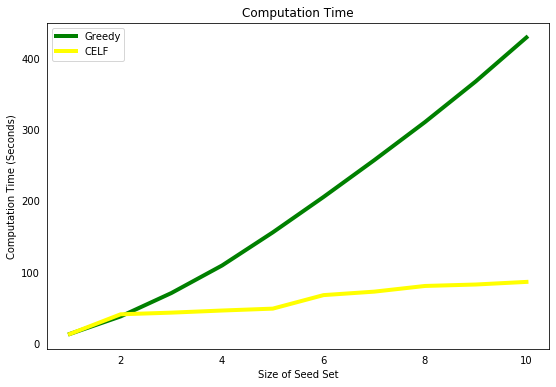

In [88]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output1[2])+1),greedy_output1[2],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[2])+1),celf_output1[2],label="CELF",color="yellow")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);


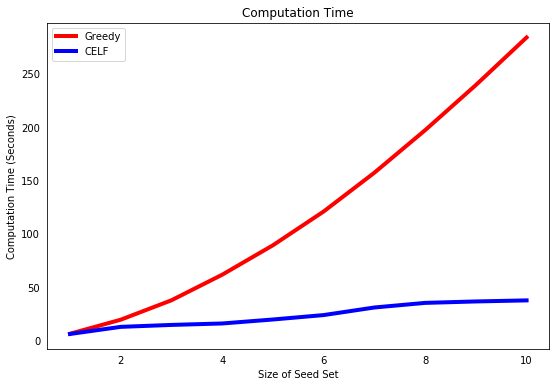

In [89]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output2[2])+1),greedy_output2[2],label="Greedy",color="red")
plt.plot(range(1,len(celf_output2[2])+1),celf_output2[2],label="CELF",color="blue")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

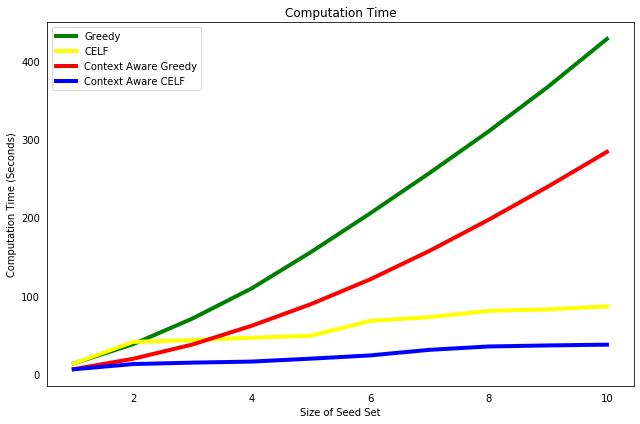

In [90]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output1[2])+1),greedy_output1[2],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[2])+1),celf_output1[2],label="CELF",color="yellow")
plt.plot(range(1,len(greedy_output2[2])+1),greedy_output2[2],label="Context Aware Greedy",color="red")
plt.plot(range(1,len(celf_output2[2])+1),celf_output2[2],label="Context Aware CELF",color="blue")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);
plt.tight_layout()
plt.savefig("g2i.jpg", dpi=300)

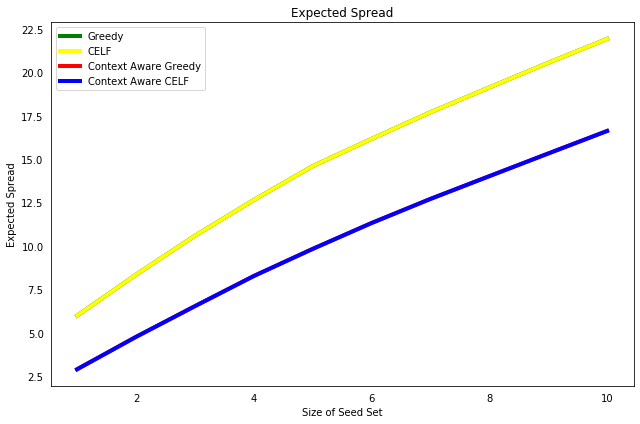

In [91]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output1[1])+1),greedy_output1[1],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[1])+1),celf_output1[1],label="CELF",color="yellow")
plt.plot(range(1,len(greedy_output2[1])+1),greedy_output2[1],label="Context Aware Greedy",color="red")
plt.plot(range(1,len(celf_output2[1])+1),celf_output2[1],label="Context Aware CELF",color="blue")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);
plt.tight_layout()
plt.savefig("g2ii.jpg", dpi=300)